In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import progressbar
import scipy.stats as sps

In [2]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)

In [3]:
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
# and by putting size by lost gas mass

def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

def get_main_branch_and_progNumb(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    numb = [[node], ]
    i = 0
    while True:
        successors = list(subtree.successors(node))
        if len(successors) == 0:
            break
        node = successors[0] # select only the first succesor (main branch)
        mpb.append(node)
        numb.append(successors)
        
    return mpb, numb


def set_view(figure, framenr, fraction):
    ipv.view(fraction*360, 0.)
    
def set_angles(fig, i, fraction):
    fig.angley = fraction*np.pi*2

# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [5]:
List = h5py.File('SatelliteList_V2_cont1R200.h5', 'r')
sats = List['SatelliteList'][()]

In [6]:
nearest, distT, velT = [], [], []
groupList = sim['SnapNumber_128/SubGroups/GroupNumber'][()]

for s in sats:
    posSat = sim['SnapNumber_128/SubGroups/SubGroupPos'][s]
    vel = sim['SnapNumber_128/SubGroups/SubGroupVel'][s]
    gro = sim['SnapNumber_128/SubGroups/GroupNumber'][s]
    ii = np.where(groupList==gro)[0][1:] # ignore the first one, is teh central and I don't care about it
    if ii.size>1:
        ij = np.where(ii!=s)
        ii2 = ii[ij] # remove teh same galaxy from the list
        posOtherGals = sim['SnapNumber_128/SubGroups/SubGroupPos'][ii2]
        dist = np.sqrt((posOtherGals[:,0]-posSat[0])**2.+(posOtherGals[:,1]-posSat[1])**2.+(posOtherGals[:,2]-posSat[2])**2.)
        mdist = dist.min()
        k = np.where(dist==mdist)[0][0]
        j = ii2[k]
        velOther = sim['SnapNumber_128/SubGroups/SubGroupVel'][j]
        difVel = np.sqrt(np.sum((vel-velOther)**2))
        nearest.append(j)
        distT.append(mdist)
        velT.append(difVel)
    else:
        nearest.append(-1) # there's no nearest galaxy
        distT.append(-1)
        velT.append(-1)

In [7]:
nearest, distT, velT = np.array(nearest), np.array(distT), np.array(velT)

In [8]:
ij = np.where(nearest>=0)
cent = List['SatelliteCentral'][()]

satS, cenS, nearS , distS, velS = sats[ij], cent[ij], nearest[ij], distT[ij], velT[ij]

In [9]:
# lets go back in time, at a time when the tow galaxies where separated.

def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb


def sepTime(sat, near, cent):
    unique = int(128*1e6+sat)
    uniqueC = int(128*1e6+cent)
    uniqueN = int(128*1e6+near)
    
    stree = networkx.dfs_tree(trees, str(unique))
    mtree = get_main_branch_unique_ids(stree, str(unique))
    
    streeC = networkx.dfs_tree(trees, str(uniqueC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
    streeN = networkx.dfs_tree(trees, str(uniqueN))
    mtreeN = get_main_branch_unique_ids(streeN, str(uniqueN))
    
    for m, mC, mN in zip(mtree, mtreeC, mtreeN):
        snap, nu = split_unique_id(int(m))
        snapC, nuC = split_unique_id(int(mC))
        snapN, nuN = split_unique_id(int(mN))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][nu]
        groupN = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snapN)][nuN]
        groupC = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snapC)][nuC]
        
        if groupC!=group and groupC!=groupN: # both galaxies are outside the group
            pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][nu]
            pnear = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapN)][nuN]
            
            vgal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][nu]
            vnear = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snapN)][nuN]
            
            dist = np.sqrt(np.sum((pgal-pnear)**2.))
            velR = np.sqrt(np.sum((vgal-vnear)**2.))
            return snap, nu, snapN, nuN, dist, velR, groupN==group
        
    return None, None, None, None, None, None, False

In [10]:
sepTime(satS[-1], nearS[-1], cenS[-1])

(126, 5388, 126, 5387, 17.69189, 29.326906, True)

In [11]:
distS[-1], velS[-1]

(15.162216186523438, 29.631729125976562)

In [12]:
# ok, all of them.
distThen, velThen, snapThen, idThen, snapNear, idNear, sameG = [], [], [], [], [], [], []

iss = []
k = np.arange(satS.size)

for ki, s, c, n in zip(k, satS, cenS, nearS):
    snap, nu, snapN, nuN, dist, velR, isin = sepTime(s, n, c)
    if snap!=None:
        iss.append(ki)
        snapThen.append(snap)
        idThen.append(nu)
        snapNear.append(snapN)
        idNear.append(nuN)
        distThen.append(dist)
        velThen.append(velR)
        sameG.append(isin)
        
distThen, velThen, snapThen = np.array(distThen), np.array(velThen), np.array(snapThen)
idThen, snapNear, idNear, sameG = np.array(idThen), np.array(snapNear), np.array(idNear), np.array(sameG)

In [15]:
iss = np.array(iss)

distSi, velSi = distS[iss], velS[iss]

Text(0, 0.5, 'vel/vel z=0')

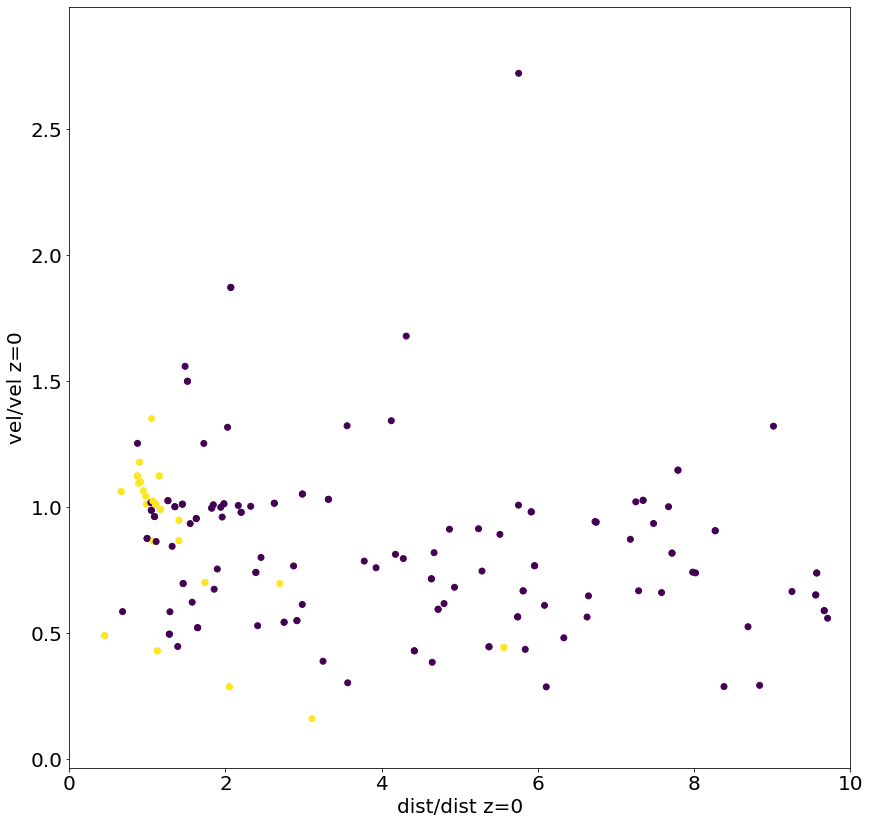

In [22]:
pl.figure(figsize=(14,14))

DD = distThen/distSi
VV = velThen/velSi

pl.scatter(DD, VV, c=sameG)
#bar = pl.colorbar() # idk what is going to do this

pl.xlim(0,10)

pl.xlabel('dist/dist z=0')
pl.ylabel('vel/vel z=0')

In [20]:
with h5py.File('SatelliteList_V2_Pairs.h5', 'w') as f:
    f.create_dataset('SatelliteList', data=satS[iss])
    f.create_dataset('SatelliteCentral', data=cenS[iss])
    f.create_dataset('difDist', data=DD)
    f.create_dataset('difVel', data=VV)
    f.create_dataset('inGroup', data=sameG)